In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Abrindo o Dataset

O Dataset está armazenado como "mnist_train.csv" e "mnist_test.csv", cada linha possui 785 números e representa uma imagem. O primeiro número de cada linha representa o Label (dígito da imagem). Os demais 784 números são os pixels da imagem 28x28.

In [2]:
data_path = "./dataset/mnist_number/"
save_model_path = './trained_models/mnist_number/'

train_data = np.loadtxt(data_path + "mnist_train.csv", 
                        delimiter=",")
test_data = np.loadtxt(data_path + "mnist_test.csv", 
                       delimiter=",") 

In [3]:
print('Train shape: {}'.format(train_data.shape))
print('Teste shape: {}'.format(test_data.shape))

Train shape: (60000, 785)
Teste shape: (2243, 785)


#### Reduzir o tamanho para uma POC inicial

In [4]:
train_data = train_data[:10000]
test_data = test_data[:1000]

In [5]:
label = train_data[0][0]
img = train_data[0][1:].reshape((28,28,1)) # (row, cols, channel)

Label: 5.0


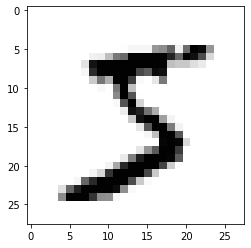

In [6]:
print('Label: {}'.format(label))
plt.imshow(img[:, :, 0], cmap="Greys")
plt.show()

In [7]:
np.max(img[0])

0.0

## Construindo o dataset para treino

In [8]:
label_train = train_data[:, 0]
img_train = train_data[:, 1:].reshape((train_data.shape[0],28,28,1))/255

label_test = test_data[:, 0]
img_test = test_data[:, 1:].reshape((test_data.shape[0],28,28,1))/255

del train_data
del test_data

In [9]:
print('img_train shape: {}'.format(img_train.shape))
print('img_test shape: {}'.format(img_test.shape))
print('label_train shape: {}'.format(label_train.shape))
print('label_test shape: {}'.format(label_test.shape))

img_train shape: (10000, 28, 28, 1)
img_test shape: (1000, 28, 28, 1)
label_train shape: (10000,)
label_test shape: (1000,)


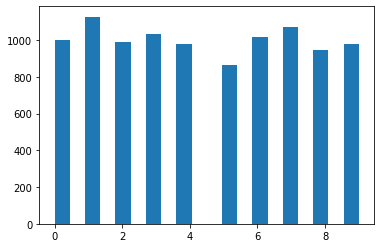

In [10]:
plt.hist(label_train, bins='auto')
plt.show()

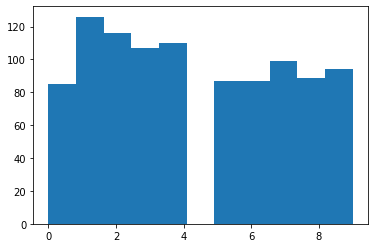

In [11]:
plt.hist(label_test, bins='auto')
plt.show()

In [12]:
def mk_class_output_multi_out(label_array):

    t = [[],[],[],[],[],[],[],[],[],[]]
    for label in label_array:
        t[int(label)].append([1])
        for a in [0,1,2,3,4,5,6,7,8,9]:
            if a != int(label):
                t[a].append([0])

    return np.array(t)

def mk_class_output_single_out(label_array):

    t = []
    for label in label_array:
        out = [0,0,0,0,0,0,0,0,0,0]
        out[int(label)]=1
        t.append(out)

    return np.array(t)

In [13]:
label_train = mk_class_output_single_out(label_train)
label_test = mk_class_output_single_out(label_test)

In [14]:
print('img_train shape: {}'.format(img_train.shape))
print('img_test shape: {}'.format(img_test.shape))
print('label_train shape: {}'.format(label_train.shape))
print('label_test shape: {}'.format(label_test.shape))

img_train shape: (10000, 28, 28, 1)
img_test shape: (1000, 28, 28, 1)
label_train shape: (10000, 10)
label_test shape: (1000, 10)


## Construindo o modelo

In [15]:
#import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.optimizers import Adam, RMSprop

#import tensorflow.keras.utils import plot_model

In [16]:
def My_ConvLSTM_Model(channels, pixels_x, pixels_y, categories):
    
    # tf2.0: Num_samples x Height x Width x Channels (NHWC)
    
    img_input  = Input(shape=(pixels_x, pixels_y, channels)
                    , name='img_input')

    first_Conv2D = Conv2D(filters=20, kernel_size=(3, 3)
                       , data_format="channels_last"
                       #, activation='tanh'
                       , padding='same')(img_input)
    first_BatchNormalization = BatchNormalization()(first_Conv2D)
    #first_Pooling = MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last')(first_BatchNormalization)

    second_Conv2D = Conv2D(filters=10, kernel_size=(3, 3)
                        , data_format="channels_last"
                        , padding='same')(first_BatchNormalization)
    second_BatchNormalization = BatchNormalization()(second_Conv2D)
    #second_Pooling = MaxPooling2D(pool_size=(3, 3), padding='same', data_format='channels_last')(second_BatchNormalization)

    #outputs = [branch(second_Pooling, 'cat_{}'.format(category)) for category in categories]
    
    third_Conv2D = Conv2D(filters=10, kernel_size=(3, 3)
                        , data_format="channels_last"
                        , padding='same')(second_BatchNormalization)
    third_BatchNormalization = BatchNormalization()(second_Conv2D)
    
    fourth_Conv2D = Conv2D(filters=10, kernel_size=(3, 3)
                        , data_format="channels_last"
                        , padding='same')(third_BatchNormalization)
    
    flat_layer = Flatten()(fourth_Conv2D)

    first_Dense = Dense(128,)(flat_layer)
    second_Dense = Dense(32,)(first_Dense)

    target = Dense(10, name='output')(second_Dense)
    

    seq = Model(inputs=img_input, outputs=target, name='Model')

    return seq

In [17]:
def branch(last_conv_layer, name):
    branch_Conv2D = Conv2D(filters=5, kernel_size=(3, 3)
                        , data_format="channels_last"
                        , padding='same')(last_conv_layer)
    branch_Pooling = MaxPooling2D(pool_size=(2, 2), padding='same', data_format="channels_last")(branch_Conv2D)

    flat_layer = Flatten()(branch_Pooling)

    first_Dense = Dense(128,)(flat_layer)
    second_Dense = Dense(32,)(first_Dense)

    target = Dense(1, name=name)(second_Dense)
    
    return target

In [18]:
channels = 1
pixels_x = 28
pixels_y = 28
categories = [i for i in range(0,10)]

In [19]:
model = My_ConvLSTM_Model(channels, pixels_x, pixels_y, categories)

In [20]:
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0001))
# other optimizer: RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.summary()

Model: "Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_input (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 20)        200       
_________________________________________________________________
batch_normalization_v2 (Batc (None, 28, 28, 20)        80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 10)        1810      
_________________________________________________________________
batch_normalization_v2_2 (Ba (None, 28, 28, 10)        40        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 10)        910       
_________________________________________________________________
flatten (Flatten)            (None, 7840)              0     

In [21]:
#plot_model(model, to_file='model_architecture_all.png', show_shapes=True, show_layer_names=True)

## Treinando o modelo

In [22]:
print('img_train shape: {}'.format(img_train.shape))
print('label_train shape: {}'.format(label_train.shape))
print('img_test shape: {}'.format(img_test.shape))
print('label_test shape: {}'.format(label_test.shape))

img_train shape: (10000, 28, 28, 1)
label_train shape: (10000, 10)
img_test shape: (1000, 28, 28, 1)
label_test shape: (1000, 10)


In [23]:
mc = ModelCheckpoint(filepath=save_model_path+'weights.{epoch:02d}.hdf5', monitor = "val_loss", 
                     verbose = 0,save_best_only = False, save_weights_only = False, period = 3)

history = model.fit(
    x=img_train, y=label_train #y=[label for label in label_train]
    , batch_size=None
    , epochs=10
    , verbose=1
    , callbacks=[mc]
    , validation_data=(img_test, label_test)#[label for label in label_test])
    , shuffle=True
    #, initial_epoch=0
    
    #, steps_per_epoch=300
    #, validation_steps=100
)

Train on 10000 samples, validate on 1000 samples
Epoch 1/10
10000/10000 [==============================] - 43s 4ms/sample - loss: 0.3030 - val_loss: 0.1157
Epoch 2/10
10000/10000 [==============================] - 56s 6ms/sample - loss: 0.0587 - val_loss: 0.0673
Epoch 3/10
10000/10000 [==============================] - 53s 5ms/sample - loss: 0.0527 - val_loss: 0.0569
Epoch 4/10
10000/10000 [==============================] - 50s 5ms/sample - loss: 0.0486 - val_loss: 0.0531
Epoch 5/10
10000/10000 [==============================] - 48s 5ms/sample - loss: 0.0471 - val_loss: 0.0568
Epoch 6/10
10000/10000 [==============================] - 56s 6ms/sample - loss: 0.0451 - val_loss: 0.0506
Epoch 7/10
10000/10000 [==============================] - 49s 5ms/sample - loss: 0.0443 - val_loss: 0.0497
Epoch 8/10
10000/10000 [==============================] - 56s 6ms/sample - loss: 0.0432 - val_loss: 0.0510
Epoch 9/10
10000/10000 [==============================] - 53s 5ms/sample - loss: 0.0421 - val_l

## Visualizando o treinamento

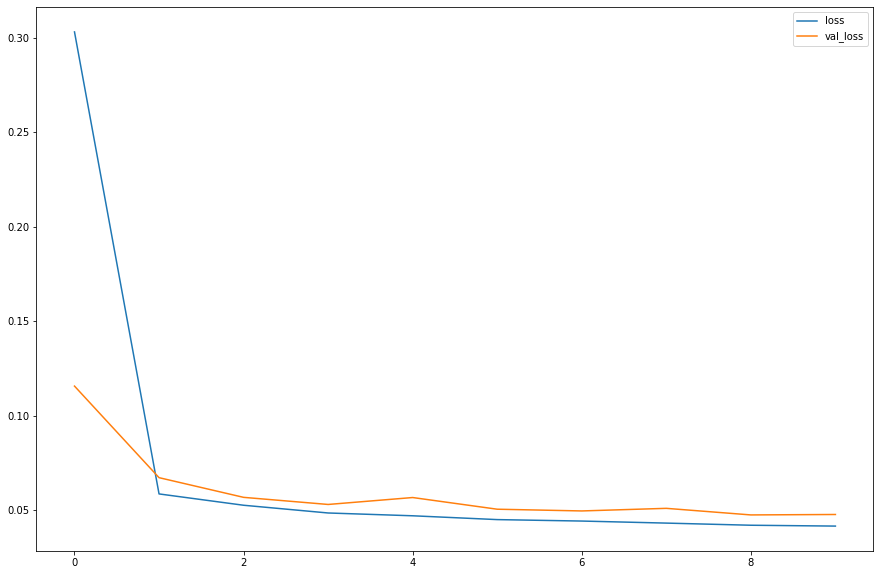

In [24]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend(loc='best')
plt.show()

## Salvando o modelo

In [25]:
import json

In [26]:
file_name = save_model_path + 'number_cnn_single_out'
model.save(file_name+'.h5')

In [27]:
with open(file_name+'_History.json', 'w') as f:
    json.dump(history.history, f)

## Carregando o modelo

Para ver se acerta na classificação

In [28]:
from tensorflow.keras.models import load_model

def get_pred_value(prediction):
    return np.unravel_index(np.argmax(prediction, axis=None), prediction.shape)[1]

def get_target_value(prediction):
    return np.unravel_index(np.argmax(prediction, axis=None), prediction.shape)[0]

In [29]:
#model = load_model(save_model_path + 'number_cnn_single_out.h5')
model = load_model(save_model_path + 'weights.03.hdf5')

In [30]:
id_test_array = 400

Label: 2
Prediction: 2


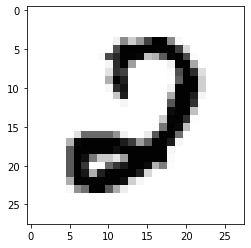

In [31]:
print('Label: {}'.format(int(get_target_value(label_test[id_test_array]))))
print('Prediction: {}'.format(get_pred_value(model.predict(img_test[id_test_array:id_test_array+1]))))
plt.imshow(img_test[id_test_array][:, :, 0], cmap="Greys")
plt.show()